In [1]:
import os
import io
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from preprocessing import parse_aug_fn, parse_fn

In [2]:
y_true = [2, 1, 0, 2, 2, 0, 1, 1]
y_pred = [0, 1, 0, 2, 2, 0, 2, 1]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
print(cm)

[[2 0 0]
 [0 2 1]
 [1 0 2]]


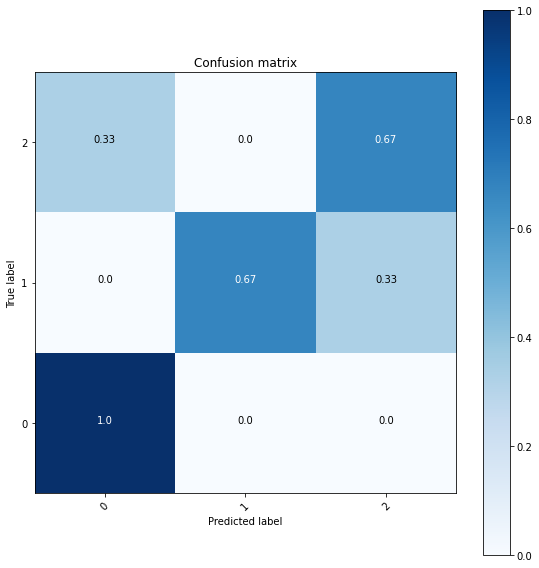

In [3]:
def plot_confusion_matrix(cm, class_names):
    """
    產生一張圖表示的Confusion matrix
    
    Args:
    cm (shape = [n, n]): 傳入Confusion matrix
    class_names (shape = [n]): 傳入類別
    """
    # 標準化confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_index = np.arange(len(class_names))
    # matplotlib 3.1.1 bug，如果不設定ylim在[-0.5~2.5]，圖片y軸範圍會被縮小成[0~2]
    plt.ylim([-0.5, 2.5])
    # Y軸顯示類別名稱
    plt.yticks(tick_index, class_names)
    # X軸顯示類別名稱，並將類別名稱旋轉45度(避免文字重疊)
    plt.xticks(tick_index, class_names, rotation=45)
    # 再圖片右邊產生一條顏色刻度條
    plt.colorbar()

    # 在每一格Confusion matrix輸入預測百分比
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # 如果格內背景顏色太深使用白色文字顯示，反之使用黑色文字
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # 將圖片的位置進行調整，避免x或y軸的文字被遮擋
    plt.tight_layout()
    return figure

# Example
img = plot_confusion_matrix(cm, [0, 1, 2])

In [4]:
def plot_to_image(figure):
    """將Matplotlib plot的圖片轉TensorFlow的張量格式"""
    # 將Matplotlib plot的圖片以PNG的格式儲存到記憶體中
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # 關閉plt圖片，防止圖片直接顯示在Jupyter notebook介面中
    plt.close(figure)
    buf.seek(0)
    # 將記憶體中的資料轉成TensorFlow格式
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

In [5]:
# Example
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
img = plot_confusion_matrix(cm, [0, 1, 2])
img_show = plot_to_image(img)

In [6]:
class ConfusionMatrix(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, test_data, class_name):
        super(ConfusionMatrix, self).__init__()
        self.log_dir = log_dir
        self.test_data = test_data
        self.class_names = class_name
        self.num_classes = len(class_name)

    def on_train_begin(self, logs=None):
        path = os.path.join(self.log_dir, 'confusion_matrix')
        # 創建TensorBoard紀錄檔
        self.writer = tf.summary.create_file_writer(path)

    def on_epoch_end(self, epoch, logs=None):
        # 計算Confusion matrix
        total_cm = np.zeros([10, 10])
        for x, y_true in self.test_data:
            y_pred = self.model.predict(x)
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_true, axis=1)
            cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes).numpy()
            total_cm += cm
        
        # 將Confusion matrix轉成Matplotlib圖片
        figure = plot_confusion_matrix(total_cm, class_names=self.class_names)
        # 將Matplotlib圖片轉成TensorFlow型式的圖片
        cm_image = plot_to_image(figure)

        # 將圖片紀錄在TensorBoard log中
        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [7]:
# 將train Data重新分成9:1等分，分別分給train data, valid data
train_split, valid_split = ['train[:90%]', 'train[90%:]']
# 取得訓練數據，並順便讀取data的資訊
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
# 取得驗證數據
valid_data = tfds.load("cifar10", split=valid_split)
# 取得測試數據
test_data = tfds.load("cifar10", split=tfds.Split.TEST)
# 取得CIFAR-10數據集的類別
class_name = info.features['label'].names

ParseError: Failed to construct dataset cifar10Message type "tensorflow_datasets.DatasetInfo" has no field named "moduleName".
 Available Fields(except extensions): ['name', 'description', 'version', 'citation', 'sizeInBytes', 'downloadSize', 'location', 'downloadChecksums', 'schema', 'splits', 'supervisedKeys', 'redistributionInfo']

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

train_data = train_data.shuffle(train_num)  # 打散資料集
# 載入預處理「 parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [10]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='glorot_uniform')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(256, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [11]:
# 儲存訓練記錄檔
logs_dirs = 'lab7-logs-images'
model_cbk = keras.callbacks.TensorBoard(logs_dirs)
# 儲存Confusion matrix圖片
save_cm = ConfusionMatrix(logs_dirs, test_data, class_name)

In [12]:
model_1.compile(keras.optimizers.Adam(), 
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                metrics=[keras.metrics.CategoricalAccuracy()])

In [13]:
model_1.fit(train_data,
            epochs=100, 
            validation_data=valid_data,
            callbacks=[model_cbk, save_cm])

Epoch 1/100
  6/704 [..............................] - ETA: 1:02 - loss: 2.3115 - categorical_accuracy: 0.1120WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


704/704 [==============================] - 27s 20ms/step - loss: 2.1048 - categorical_accuracy: 0.1911 - val_loss: 1.8739 - val_categorical_accuracy: 0.3134
Epoch 2/100
704/704 [==============================] - 13s 19ms/step - loss: 1.9776 - categorical_accuracy: 0.2470 - val_loss: 1.8446 - val_categorical_accuracy: 0.3356oss: 1.9839 - categorica - ETA: 1s - loss: - ETA: 0s - loss: 1.9785 - categorical_
Epoch 3/100
704/704 [==============================] - 13s 19ms/step - loss: 1.8748 - categorical_accuracy: 0.3073 - val_loss: 1.6121 - val_categorical_accuracy: 0.4140
Epoch 4/100
704/704 [==============================] - 13s 19ms/step - loss: 1.7383 - categorical_accuracy: 0.3660 - val_loss: 1.3785 - val_categorical_accuracy: 0.5128
Epoch 5/100
704/704 [==============================] - 13s 19ms/step - loss: 1.6464 - categorical_accuracy: 0.4083 - val_loss: 1.3163 - val_categorical_accuracy: 0.5202
Epoch 6/100
704/704 [==============================] - 13s 19ms/step - loss: 1.5621 -

Epoch 95/100
704/704 [==============================] - 14s 19ms/step - loss: 0.7852 - categorical_accuracy: 0.7396 - val_loss: 0.6537 - val_categorical_accuracy: 0.7884
Epoch 96/100
704/704 [==============================] - 14s 19ms/step - loss: 0.7747 - categorical_accuracy: 0.7438 - val_loss: 0.6507 - val_categorical_accuracy: 0.7912
Epoch 97/100
704/704 [==============================] - 14s 19ms/step - loss: 0.7756 - categorical_accuracy: 0.7431 - val_loss: 0.6716 - val_categorical_accuracy: 0.7842
Epoch 98/100
704/704 [==============================] - 14s 19ms/step - loss: 0.7893 - categorical_accuracy: 0.7393 - val_loss: 0.7134 - val_categorical_accuracy: 0.7728
Epoch 99/100
704/704 [==============================] - 14s 19ms/step - loss: 0.7860 - categorical_accuracy: 0.7432 - val_loss: 0.6516 - val_categorical_accuracy: 0.7870
Epoch 100/100
704/704 [==============================] - 14s 19ms/step - loss: 0.7774 - categorical_accuracy: 0.7415 - val_loss: 0.6419 - val_categori

In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
# 從資料夾中的preprocessing.py檔案中Import parse_aug_fn和parse_fn函數
from preprocessing import parse_aug_fn, parse_fn

In [2]:
from tensorboard.plugins.hparams import api as hp

In [3]:
hparam_ia = hp.HParam('Imgae_Augmentation', hp.Discrete([False, True]))
hparam_bn = hp.HParam('Batch_Normalization', hp.Discrete([False, True]))
hparam_init = hp.HParam('Weight_Initialization', hp.Discrete(['RandomNormal_0.01std', 'glorot_normal', 'he_normal']))
hparam_lr = hp.HParam('Learning_Rate', hp.Discrete([0.001, 0.01, 0.03]))

In [4]:
logs_dors = os.path.join('lab7-logs-hparams', 'hparam_tuning')
root_logdir_writer = tf.summary.create_file_writer(logs_dirs)
#with root_logdir_writer.as_default ():
#    hp.hparams_config(hparams=[hp_ia , hp_bn, hp_init, hp_lr], metrics=[hp_metric])

metric = 'Accuracy'
log_dirs = "lab7-logs-hparams/hparam_tuning"
with tf.summary.create_file_writer(log_dirs).as_default():
    hp.hparams_config(
        hparams=[hparam_ia, hparam_bn, hparam_init, hparam_lr],
        metrics=[hp.Metric(metric, display_name='Accuracy')],
    )

NameError: name 'logs_dirs' is not defined

In [97]:
train_split, valid_split = ['train[:90%]', 'train[90%:]']
train_data_noaug, info = tfds.load("cifar10", split=train_split,with_info=True)
train_data_aug = tfds.load("cifar10", split=train_split)
valid_data = tfds.load("cifar10", split=valid_split)

In [98]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
# 將train Data重新分成1:9等分，分別分給valid data, train data
train_split, valid_split = ['train[:90%]', 'train[90%:]']

# 取得訓練數據
train_data_noaug, info = tfds.load("cifar10", split=train_split, with_info=True)
train_data_aug = tfds.load("cifar10", split=train_split)
# 取得驗證數據
valid_data = tfds.load("cifar10", split=valid_split)

train_num = int(info.splits['train'].num_examples / 5) * 4  # 訓練資料數量

train_data_noaug = train_data_noaug.shuffle(train_num)  # 打散資料集
# 載入預處理「 parse_aug_fn」function，cpu數量為自動調整模式
train_data_noaug = train_data_noaug.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
train_data_noaug = train_data_noaug.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

train_data_aug = train_data_aug.shuffle(train_num)  # 打散資料集
# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
train_data_aug = train_data_aug.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
train_data_aug = train_data_aug.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [99]:
class HyperparameterCallback(tf.keras.callbacks.Callback):
    # 類別創建時調用
    def __init__(self, log_dir, hparams):
        super(HyperparameterCallback, self).__init__()
        self.log_dir = log_dir
        self.hparams = hparams
        self.best_accuracy = 0
        self.writer = None
        
    # 訓練開始前調用
    def on_train_begin(self, logs=None):
        self.writer = tf.summary.create_file_writer(self.log_dir)

    # 每一個Epcoh結束後調用
    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_categorical_accuracy')
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            
    # 訓練結束時調用
    def on_train_end(self, logs=None):
        with self.writer.as_default():
            hp.hparams(self.hparams)  # record the values used in this trial
            tf.summary.scalar(metric, self.best_accuracy, step=0)

In [100]:
def train_test_model(logs_dir, hparams):
    """
    logs_dir:傳入目前執行的任務log檔的位置
    hparams:傳入超參數
    """
    # 指派網路模型初始化的方法
    if hparams[hparam_init] == "glorot_normal":
        init = keras.initializers.glorot_normal()
    elif hparams[hparam_init] == "he_normal":
        init = keras.initializers.he_normal()
    else:
        init = keras.initializers.RandomNormal(0, 0.01)

    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, (3, 3), kernel_initializer=init)(inputs)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    # 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
    model = keras.Model(inputs, outputs, name='model')

    # 儲存訓練記錄檔
    model_tb = keras.callbacks.TensorBoard(log_dir=logs_dir, write_graph=False)

    # 儲存最好的網路模型權重
    model_mckp = keras.callbacks.ModelCheckpoint(logs_dir +'/best-model.hdf5', 
                                                 monitor='val_categorical_accuracy', 
                                                 save_best_only=True, 
                                                 mode='max')
    
    # 設定停止訓練的條件(當Accuracy超過30迭代沒有上升的話訓練會終止)
    model_els = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy' , 
                                              min_delta=0, 
                                              patience=30, 
                                              mode='max')
    # 客自化超參數回調函式，紀錄訓練模型的超參數和指標(準確率)
    model_hparam = HyperparameterCallback(logs_dir + 'hparam_tuning', hparams)


    # 設定訓練使用的優化器、損失函數和指標函數
    # 優化器學習率為超參數：0.001、0.01或0.03
    model.compile(keras.optimizers.Adam(hparams[hparam_lr]), 
                  loss=keras.losses.CategoricalCrossentropy(), 
                  metrics=[keras.metrics.CategoricalAccuracy()])
    
    # 超參數：使用「經過影像增強的數據」或「不經過影像增強的數據」訓練網路
    if hparams[hparam_ia]:
        history = model.fit(train_data_aug,
                            epochs=2, 
                            validation_data=valid_data,
                            callbacks=[model_tb, model_mckp, model_els, model_hparam])
    else:
        history = model.fit(train_data_noaug,
                            epochs=2, 
                            validation_data=valid_data,
                            callbacks=[model_tb, model_mckp, model_els, model_hparam])

In [101]:
session_id = 1  # 訓練任務的id
for ia in hparam_ia.domain.values:
    for bn in hparam_bn.domain.values:
        for init in hparam_init.domain.values:
            for lr in hparam_lr.domain.values:
                # 顯示目前訓練任務id
                print('--- Running training session {}'.format(session_id))
                # 設定本次訓練的超參數
                hparams = {hparam_ia: ia, hparam_bn: bn, hparam_init: init, hparam_lr: lr}
                # 儲放紀錄檔的位置
                logs_dir = os.path.join("lab7-logs-hparams", "run-{}".format(session_id))
                # 建立、編譯及訓練網路模型
                train_test_model(logs_dir, hparams)
                session_id += 1  # id+1

--- Running training session 1
Epoch 1/2
  6/704 [..............................] - ETA: 51s - loss: 2.3027 - categorical_accuracy: 0.1094 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0109s vs `on_train_batch_end` time: 0.0535s). Check your callbacks.


704/704 [==============================] - 14s 19ms/step - loss: 2.3027 - categorical_accuracy: 0.1000 - val_loss: 2.3027 - val_categorical_accuracy: 0.0990
Epoch 2/2
704/704 [==============================] - 13s 18ms/step - loss: 2.3027 - categorical_accuracy: 0.0973 - val_loss: 2.3029 - val_categorical_accuracy: 0.09401s - los
--- Running training session 2
Epoch 1/2
  6/704 [..............................] - ETA: 1:04 - loss: 2.7879 - categorical_accuracy: 0.0911WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0106s vs `on_train_batch_end` time: 0.0694s). Check your callbacks.


704/704 [==============================] - 14s 19ms/step - loss: 2.3078 - categorical_accuracy: 0.0991 - val_loss: 2.3045 - val_categorical_accuracy: 0.0994
Epoch 2/2
704/704 [==============================] - 13s 18ms/step - loss: 2.3039 - categorical_accuracy: 0.0986 - val_loss: 2.3035 - val_categorical_accuracy: 0.1000categorical_accuracy:  - ETA
--- Running training session 3
Epoch 1/2
  6/704 [..............................] - ETA: 50s - loss: 77.9932 - categorical_accuracy: 0.0651  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0100s vs `on_train_batch_end` time: 0.0525s). Check your callbacks.


704/704 [==============================] - 14s 19ms/step - loss: 2.9515 - categorical_accuracy: 0.0975 - val_loss: 2.3071 - val_categorical_accuracy: 0.1006
Epoch 2/2
704/704 [==============================] - 13s 18ms/step - loss: 2.3053 - categorical_accuracy: 0.0977 - val_loss: 2.3072 - val_categorical_accuracy: 0.0940
--- Running training session 4
Epoch 1/2
  6/704 [..............................] - ETA: 52s - loss: 2.3228 - categorical_accuracy: 0.0964 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0104s vs `on_train_batch_end` time: 0.0546s). Check your callbacks.


704/704 [==============================] - 14s 19ms/step - loss: 1.9040 - categorical_accuracy: 0.2742 - val_loss: 1.5196 - val_categorical_accuracy: 0.4374
Epoch 2/2
704/704 [==============================] - 13s 18ms/step - loss: 1.5155 - categorical_accuracy: 0.4432 - val_loss: 1.2809 - val_categorical_accuracy: 0.5350
--- Running training session 5
Epoch 1/2
  6/704 [..............................] - ETA: 51s - loss: 63.7466 - categorical_accuracy: 0.1042  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0104s vs `on_train_batch_end` time: 0.0531s). Check your callbacks.


199/704 [=======>......................] - ETA: 9s - loss: 4.2617 - categorical_accuracy: 0.0944 - ETA: 13s - loss: 7.1142  - ETA: 10s - loss: 4.5691 - categorical_a

KeyboardInterrupt: 

In [1]:
%load_ext tensorboard
%tensorboard --port 9875 --logdir lab7-logs-images